# Implementation of Wu et al Spatio-Temporal Back Propagation.
### Manual implementation of neurons

# Dynamic

* input of neuron i at layer n at time t+1
$$x^{t+1, n}_i = \sum_{j=1}^{l(n-1)} w_{i,j}^n.o_j^{t+1,n-1}$$
which is:
$$X^{t+1,n}=W^nO^{t+1,n-1}$$

* voltage of neuron i of layer n at time t+1
$$u_i^{t+1, n}= u_i^{t, n}f(o_i^{t,n})+x_i^{t+1, n} + b_i^n$$
which is:
$$U^{t+1,n} = U^{t,n}\odot f(O^{t,n}) + X^{t+1, n} + b^n$$

* output of neuron i of the layer n at time t+1
$$o_i^{t+1, n} = g(u_i^{t+1, n})$$
which is :
$$O^{t+1, n}=g(U^{t+1, n})$$

with $f(t) = \tau e^{-\frac{t}{\tau}}$ and $g(t) = \mathbb{1}_{t\geqslant V_{th}}$

# Derivatives

Denote $\frac{\partial L}{\partial o_i^{t,n}} = \delta_i^{t,n}$ and $\frac{\partial L}{\partial u_i^{t,n}} = \varepsilon_i^{t,n}$
with
$$ L = \frac{1}{2S}\sum_{s=1}^S\|Y_s - \frac{1}{T}\sum_{t=1}^T O_s^{t,N}\|^2_2$$
### case $t=T$ and $n=N$

$$\delta_i^{T,N} = - \frac{1}{TS}(y_i - \frac{1}{T}\sum_{k=1}^To_i^{k,N})$$
and 
$$\varepsilon_i^{T,N} = \delta_i^{T,N}.\frac{\partial g}{\partial u_i^{T,N}}$$

so in vector notations:

$$\Delta^{T,N} = -\frac{1}{TS}(Y - \frac{1}{T}\sum_{t=1}^TO^{t,N})$$
and
$$E^{T,N} = \Delta^{T,N} \odot \frac{\partial g}{\partial U^{T,N}}$$

### case $t=T$ and $n < N$

$$\delta_i^{T,n} = \sum_{j=1}^{l(n+1)}\delta_j^{T,n+1}w_{ji}^{n+1}\frac{\partial g}{\partial u_j^{T,n+1}}$$
and 
$$\varepsilon_i^{T,n} = \delta_i^{T,n}.\frac{\partial g}{\partial u_i^{T,n}}$$

so in vector notations:

$$\Delta^{T,n} = (W^{n+1})^\star(\Delta^{T,n+1}\odot \frac{\partial g}{\partial U^{T,n+1}})$$
and
$$E^{T,n} = \Delta^{T,n} \odot \frac{\partial g}{\partial U^{T,n}}$$


### case $t<T$ and $n=N$

$$\delta_i^{t,N} = \delta_i^{T,N} + \delta_i^{t+1,N}.u_i^{t,N}.\frac{\partial g}{\partial u_i^{t+1,N}}.\frac{\partial f}{\partial o_i^{t,N}}$$

and 

$$\varepsilon_i^{t,N} = \delta_i^{t,N}.\frac{\partial g}{\partial u_i^{t,N}} + \varepsilon_i^{t+1,N}.f(o_i^{t,N})$$

so in vector notations:
$$\Delta^{t,N} = \Delta^{T,N} + \Delta^{t+1,N}\odot U^{t,N}\odot \frac{\partial g}{\partial U^{t+1,N}}\odot\frac{\partial f}{\partial O^{t,N}}$$
and
$$E^{t,N} = \Delta^{t,N}\odot \frac{\partial g}{\partial U^{t,N}} + E^{t+1,N}\odot f(O^{t,N})$$

### case $t<T$ and $n<N$
$$\delta_i^{t,n} = \sum_{j=1}^{l(n+1)}\delta_j^{t,n+1}w_{ji}^{n+1}\frac{\partial g}{\partial u_j^{t,n+1}} + \delta_i^{t+1,n}.u_i^{t,n}.\frac{\partial g}{\partial u_i^{t+1,n}}\frac{\partial f}{\partial o_i^{t,n}}$$
and
$$\varepsilon_i^{t,n} = \delta_i^{t,n}.\frac{\partial g}{\partial u_i^{t,n}} + \varepsilon_i^{t+1,n}.f(o_i^{t,n})$$

so in vector notations:

$$\Delta^{t,n} = (W^{n+1})^\star(\Delta^{t,n+1} \odot \frac{\partial g}{\partial U^{t, n+1}}) + \Delta^{t+1,n}\odot U^{t,n}\odot \frac{\partial g}{\partial U^{t+1,n}}\odot\frac{\partial f}{\partial O^{t,n}}$$

and

$$E^{t,n} = \Delta^{t,n}\odot \frac{\partial g}{\partial U^{t,n}} + E^{t+1,n}\odot f(O^{t,n})$$

Where $U\odot V$ is the componentwise product and $M^\star$ is the transpose matrix of $M$

In the end, we have that:
$$\frac{\partial L}{\partial b^n} = \sum_{t=1}^T\frac{\partial L}{\partial U^{t,n}} = \sum_{t=1}^TE^{t,n}$$
and
$$\frac{\partial L}{\partial W^n} = \sum_{t=1}^T\frac{\partial L}{\partial U^{t,n}}.(O^{t, n-1})^\star = \sum_{t=1}^TE^{t,n}.(O^{t, n-1})^\star$$

In [41]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import matplotlib.pyplot as plt
import data_loader
from model import LIF_net, Solver
import time
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load MNIST dataset

In [51]:
num_classes = 10
(x_train, y_train),(x_test, y_test) = data_loader.load(path='../dataset')
one_hot_train, one_hot_test = data_loader.one_hot_encode(y_train, y_test, num_classes)

`ber(p)` transforms a grey scale image in `0,1` spikes image. See exemples below.

In [7]:
def ber(p):
    return np.array(np.random.random(p.shape) <= p, np.int)

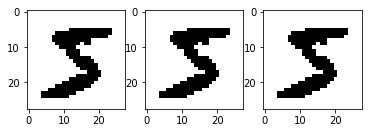

In [8]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(ber(x_train[0]).reshape((28,28)), cmap=plt.cm.binary)
plt.show()

Create a model with 10 time steps of exposition. The run it without training on the 3 first training sample. Display the accumulated potential and the accumulated spikes in the output of the network and the transformed image that is fed to it.

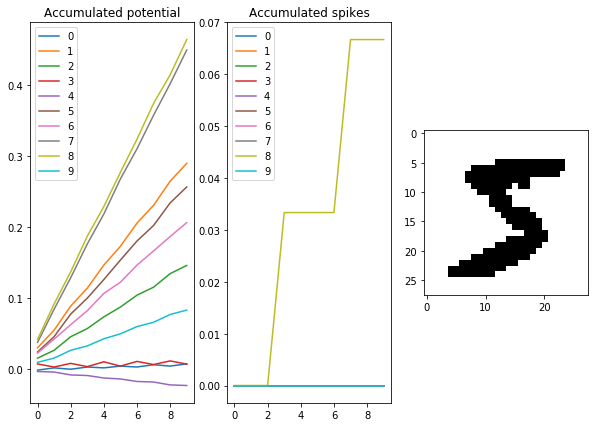

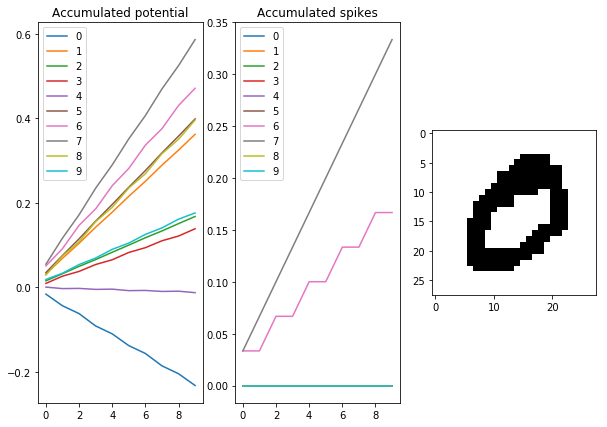

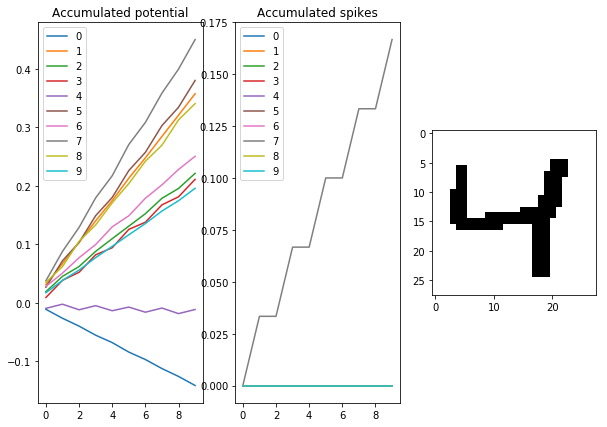

In [44]:
model = LIF_net(T=10)
num_samples = 3
samples = x_train[:num_samples]
model.run(samples)

cumU = np.cumsum(model.out.potential, axis=0)/30.
cumO = np.cumsum(model.out.spikes, axis=0)/30.
idx = np.arange(num_classes)
for i in range(num_samples):
    U = cumU[:, i, :]
    O = cumO[:, i, :]
    #print("True label is", y_train[i])
    plt.figure(i, figsize=(10,7))
    plt.subplot(131)
    plt.plot(U)
    plt.legend(idx)
    plt.title("Accumulated potential")
    plt.subplot(132)
    plt.plot(O)
    plt.legend(idx)
    plt.title("Accumulated spikes")
    plt.subplot(133)
    plt.imshow(np.reshape(ber(samples[i]), (28,28)), cmap=plt.cm.binary)

Full training of the model. Obtained `0.9593` accuracy on the full training set.

In [56]:
solver = Solver(n_epochs=5, batch_size=10)
model = LIF_net(T=15)
start = time.time()
n_train = 1000
n_test = 100
solver.train(model, x_train[:n_train], one_hot_train[:n_train], x_test[:n_test], one_hot_test[:n_test])
stop = time.time()
print("training lasted", (stop-start)/60, "min")

epoch 1 has ended
Loss: 0.230454152918845
Train Acc.: 0.8370000000000002 Test Acc.: 0.75
epoch 2 has ended
epoch 3 has ended
Loss: 0.13450771010968976
Train Acc.: 0.9560000000000001 Test Acc.: 0.81
epoch 4 has ended
epoch 5 has ended
Loss: 0.12603901802034612
Train Acc.: 0.964 Test Acc.: 0.82
training lasted 1.2288892984390258 min


In [53]:
model.reset()
solver.eval(model, x_test, one_hot_test)

0.8444

In [54]:
model.reset()
n_samp = 3
samples = x_test[2107: 2107 + n_samp]
model.run(samples)

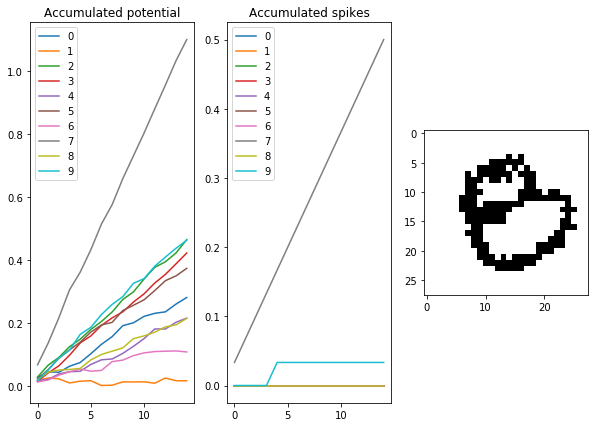

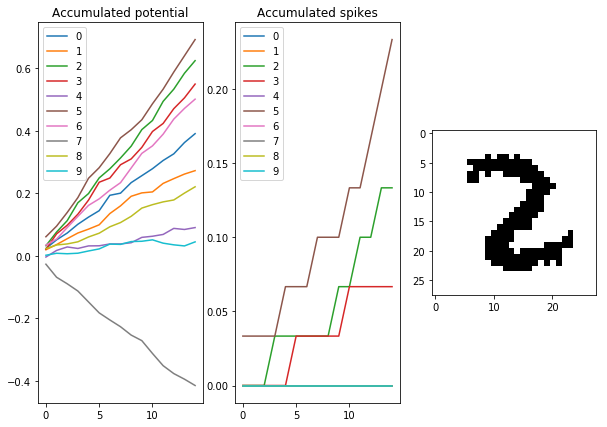

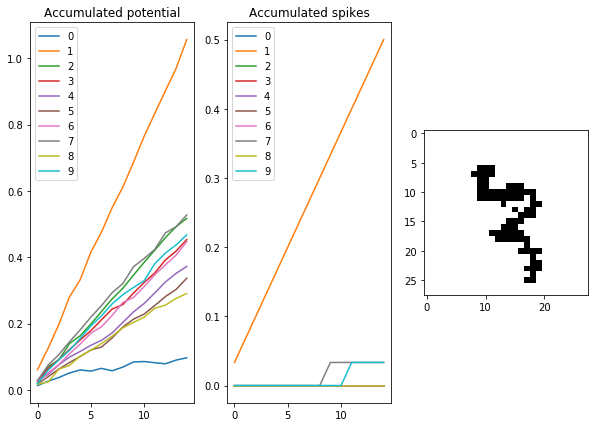

In [57]:
cumU = np.cumsum(model.out.potential, axis=0)/30.
cumO = np.cumsum(model.out.spikes, axis=0)/30.
idx = np.arange(10)
for i in range(n_samp):
    U = cumU[:, i, :]
    O = cumO[:, i, :]
    plt.figure(i, figsize=(10,7))
    plt.subplot(131)
    plt.plot(U)
    plt.legend(idx)
    plt.title("Accumulated potential")
    plt.subplot(132)
    plt.plot(O)
    plt.legend(idx)
    plt.title("Accumulated spikes")
    plt.subplot(133)
    plt.imshow(np.reshape(ber(samples[i]), (28,28)), cmap=plt.cm.binary)

In [27]:
# saving the results
import pickle

with open('bH.obj', 'wb') as bh:
    pickle.dump(model.hidden.bias, bh)
with open('WH.obj', 'wb') as wh:
    pickle.dump(model.hidden.W, wh)
with open('bO.obj', 'wb') as bo:
    pickle.dump(model.out.bias, bo)
with open('WO.obj', 'wb') as wo:
    pickle.dump(model.out.W, wo)